In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 50)
from scipy.interpolate import interp1d, interp2d

import torch
import torch.nn as nn
from scipy import integrate
from inteq import SolveFredholm

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from itertools import product as it_prod

# plotting packages 
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# !pip install scikit-optimize
import warnings
warnings.filterwarnings('ignore')

import os
import sys

from lightgbm import LGBMRegressor

from skopt import BayesSearchCV

from mpmath import mp
mp.dps = 30

# Set the environment variable to suppress LightGBM warnings
os.environ['LGBM_CONFIG'] = '--log_level=3'

# Redirect warnings to a file
sys.stderr = open('warnings.txt', 'w')


# Opening file
file1 = open('C:\\Users\\matve\\Documents\\Python Scripts\\junior_quant_task\\train.txt', 'r')
count = 0
ob_num = 0
ob = [[0] * 3 for _ in range(40)]
ordbook = [[0] * 2 for _ in range(10000)]


for line in file1:
    if ("price" in line.strip()):
#         print(pd.DataFrame(data=ob))
        ob_num = 0
        ordbook[count][1] = tuple([x for x in line.strip().split(' price: ')])
        ordbook[count][0] = pd.DataFrame(data=ob)
        ordbook[count][0].columns = ['price','amount','side']
        count +=1
    elif not ("=" in line.strip()):
        line = line.strip().split('\t')
        ob[ob_num][0] = int(line[0])
        ob[ob_num][1] = int(line[1])
        ob[ob_num][2] = line[2]
        ob_num += 1
 
# Closing files
file1.close()

ordbook = [row for row in ordbook if row[1] != 0]

print(ordbook[0][1])  

('Sell', '130895')


Buy


Text(0, 0.5, 'Amount')

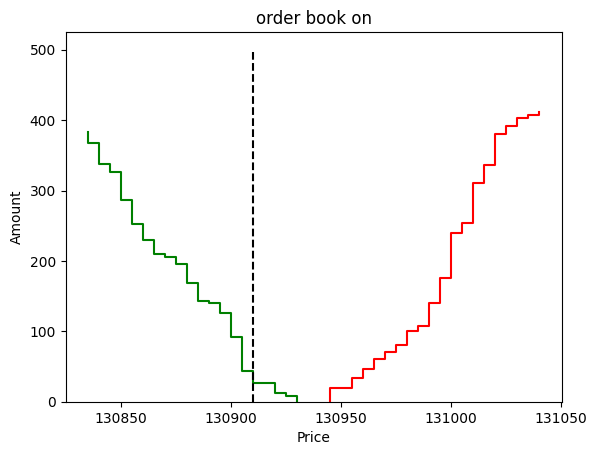

In [3]:
n=10
obsample = ordbook[n][0]
obprice = int(ordbook[n][1][1])
print(ordbook[n][1][0])

fig, ax = plt.subplots()
ax.set_title('order book on' )
sns.ecdfplot(x="price", weights="amount", stat="count", complementary=True, data=obsample[obsample.side == 'Buy'], ax=ax, color='g')
sns.ecdfplot(x="price", weights="amount", stat="count", data=obsample[obsample.side == 'Sell'], ax=ax, color='r')
l1=plt.vlines(obprice, 0, 500, color='black',ls='--')
ax.set_xlabel("Price")
ax.set_ylabel("Amount")

In [5]:
def preproc(df, order, price):
    df['quote'] = df['price']*df['amount']
    df['t'] = (-1)**(df['side']=='Buy')*df['price']
    df.set_index('side', inplace = True)

    df = df.groupby(level = 0).apply(lambda t: t.sort_values(by = 't')).droplevel(0)
    df['C'] = df['amount']+1j*df['quote']/1e+5
    
    D_cs = df.groupby(level = 0)['C'].apply(lambda t: t.cumsum()).droplevel(0)
    D_cs *= (-1)**(df['t']<0)
    D_cs = D_cs.sort_values().to_numpy()
    
    cvol, cquot = D_cs.real, D_cs.imag
    
#     print(df['D'].to_numpy())

    
    return cquot, cvol

In [6]:
anal = np.array([preproc(ob.copy(), *com) for ob, com in ordbook])

In [7]:
target = [ordbook[i][1] for i in range(9000)]
order, f_hut = zip(*target)
order = np.array(order)
f_hut = np.array(f_hut).astype(float)
# f_hut = 1e+5/f_hut
f_hut = f_hut

In [8]:
anal = anal[order=='Buy']
f_hut = f_hut[order=='Buy']

In [9]:
anal[:,0,:].min()

-3703.5072

In [10]:
x = np.linspace(anal[:,0,:].min(), anal[:,0,:].max(), 4001)
x

array([-3703.5072   , -3701.9365664, -3700.3659328, ...,  2575.8859328,
        2577.4565664,  2579.0272   ])

In [11]:
def upsample(cquot, cvol, x):
    f = interp1d(cquot, cvol, bounds_error=False, 
#                  fill_value=(np.min(cvol), np.max(cvol))
                )
    #     return np.diff(f(x))/np.diff(x)

    prc = np.diff(x)/np.diff(f(x))
    prc[np.isnan(prc)] = 0
    return prc

In [12]:
f = np.array([upsample(xt, yt, x) for xt, yt in anal])

In [13]:
f_hut.shape

(4493,)

In [14]:
f.shape

(4493, 4000)

In [15]:
x[:-1].shape

(4000,)

In [16]:
n_samples = len(f_hut)
np.arange(n_samples, dtype = float).shape

(4493,)

In [17]:
f_func = interp2d(np.arange(n_samples, dtype = float), x[:-1], f.T, kind='linear')

In [18]:
f_hut_func = interp1d(np.arange(n_samples, dtype = float), f_hut, kind='linear')

In [19]:
a, b = np.min(x), np.max(x[:-1])

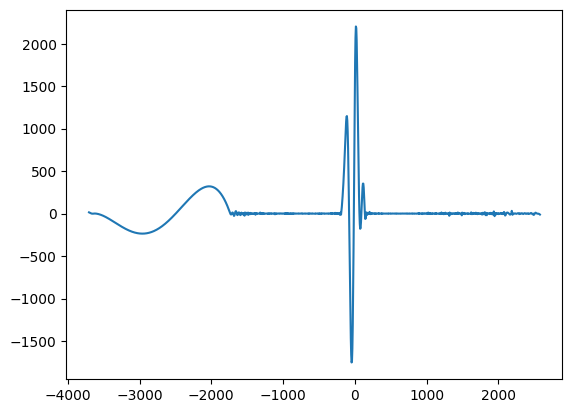

In [20]:
lam = SolveFredholm(k = lambda i,y: f_func(i.reshape(-1), y).T, 
                    f = f_hut_func, 
                    a = a, 
                    b = b, 
                    num = 1155, 
                    smin = 0, 
                    smax = n_samples-1
                   )
plt.plot(*lam)

In [21]:
# lam[1][np.abs(lam[0])>1700]=0
# plt.plot(*lam)

In [22]:
lam_func = interp1d(lam[0], lam[1])

In [23]:
# Set the desired absolute and relative error tolerances (increase precision by reducing these values)
epsabs = 1e-10  # Absolute error tolerance
epsrel = 1e-10  # Relative error tolerance

integr_total_error = 1*np.array([integrate.quad(lambda x: f_func(i, x)*lam_func(x), a, b, epsabs=epsabs, epsrel=epsrel)[0]-f_hut[i] for i in range(100)])

In [24]:
np.linalg.norm(integr_total_error)

1541.8990590919248

In [25]:
c = pd.DataFrame(lam).T

c[c[1].abs()>1e-2]

,0,1
0,-3703.507200,14.488843
1,-3698.064424,12.065993
2,-3692.621648,9.651059
3,-3687.178871,7.283633
4,-3681.736095,5.019140
...,...,...
1150,2555.685461,-0.901941
1151,2561.128238,-2.178191
1152,2566.571014,-4.660250
1153,2572.013790,-7.955320


In [27]:
error = 2000
for numerator in range(2200,5000,2):
    lam = SolveFredholm(k = lambda i,y: f_func(i.reshape(-1), y).T, 
                    f = f_hut_func, 
                    a = a, 
                    b = b, 
                    num = numerator, 
                    smin = 0, 
                    smax = n_samples-1
                   )

    lam_func = interp1d(lam[0], lam[1])

    # Set the desired absolute and relative error tolerances (increase precision by reducing these values)
    epsabs = 1e-10  # Absolute error tolerance
    epsrel = 1e-10  # Relative error tolerance

    integr_total_error = 1*np.array([integrate.quad(lambda x: f_func(i, x)*lam_func(x), a, b, epsabs=epsabs, epsrel=epsrel)[0]
                                     -f_hut[i] for i in range(100)])
    nerror =np.linalg.norm(integr_total_error)
    if (nerror < error):
        error = nerror
    print(error)


2000
1103.8343511527848
967.0685095449265
967.0685095449265
967.0685095449265
967.0685095449265
967.0685095449265
967.0685095449265
967.0685095449265
820.2936451870504
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.5598584943162
716.

MemoryError: Unable to allocate 148. MiB for an array with shape (3111, 6222) and data type float64